## Computer Vision - Assignment 5 
## Chapter 7 
### Kamal SUbedi (G35111003)


###### Q) 7.1.  Interest point detector. Implement one or more keypoint detectors and compare their performance. 

/var/folders/nf/gjk1b0x54993dfl5m_49xrp00000gn/T/ipykernel_5191/1795592635.py:12: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxima = peak_local_max(dog, min_distance=1, threshold_abs=threshold, indices=False)
/var/folders/nf/gjk1b0x54993dfl5m_49xrp00000gn/T/ipykernel_5191/1795592635.py:19: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxima = peak_local_max(laplacian, min_distance=1, threshold_abs=threshold, indices=False)


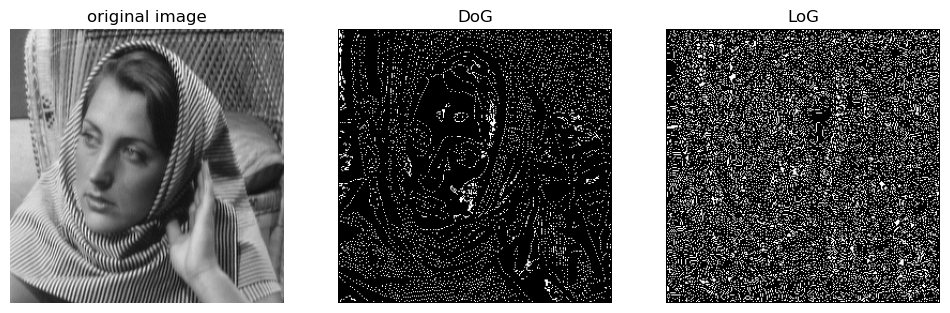

In [125]:
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
from scipy.ndimage import laplace
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt

def difference_of_gaussians_detector(image, sigma1, sigma2, threshold):
    img_smooth1 = gaussian_filter(image, sigma1)
    img_smooth2 = gaussian_filter(image, sigma2)
    dog = img_smooth1 - img_smooth2
    local_maxima = peak_local_max(dog, min_distance=1, threshold_abs=threshold, indices=False)
    keypoints = local_maxima.astype(np.uint8)
    return keypoints

def laplacian_of_gaussian_detector(image, sigma, threshold):
    img_smooth = gaussian_filter(image, sigma)
    laplacian = laplace(img_smooth)
    local_maxima = peak_local_max(laplacian, min_distance=1, threshold_abs=threshold, indices=False)
    keypoints = local_maxima.astype(np.uint8)
    return keypoints


image = cv2.imread("try1.png")
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#Difference of Gaussians (DoG) keypoints
keypoints_dog = difference_of_gaussians_detector(image_gray, 1, 5, 25)

#Laplacian of Gaussian (LoG) keypoints
keypoints_log = laplacian_of_gaussian_detector(image_gray, 3, 1)


fig, axes = plt.subplots(1, 3, figsize=(12, 8))
axes[0].imshow(image_gray, cmap='gray')
axes[0].set_title('original image')
axes[0].axis('off')

axes[1].imshow(keypoints_dog * 255, cmap='gray')
axes[1].set_title('DoG')
axes[1].axis('off')

axes[2].imshow(keypoints_log * 255, cmap='gray')
axes[2].set_title('LoG')
axes[2].axis('off')

plt.show()


###### Q) 7.3) ROC curve computation.

In [115]:
import numpy as np
import matplotlib.pyplot as plt

def roc_curve(t, f):
    T = np.cumsum(t)
    F = np.cumsum(f)
    
    fpr = []
    tpr = []
    
    for threshold in np.unique(np.concatenate((t, f))):
        tpr_current = T[t >= threshold] / np.sum(t)
        tpr = np.concatenate((tpr, tpr_current))
        
        fpr_current = F[f < threshold] / np.sum(f)
        fpr = np.concatenate((fpr, fpr_current))
    
    index = np.argsort(fpr)
    fpr = fpr[index]
    tpr = tpr[index]
    
    auc = 0
    for i in range(len(fpr) - 1):
        auc += (fpr[i + 1] - fpr[i]) * (tpr[i + 1] + tpr[i]) / 2
    
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.show()
    
    return fpr, tpr, auc

#t = np.array([0.2, 0.4, 0.6, 0.7, 1.0])
#f = np.array([0.2, 0.3, 0.6, 0.7, 0.9])
#roc_curve(t,f)

##### Q) 7.7) 7.7: Edge detector

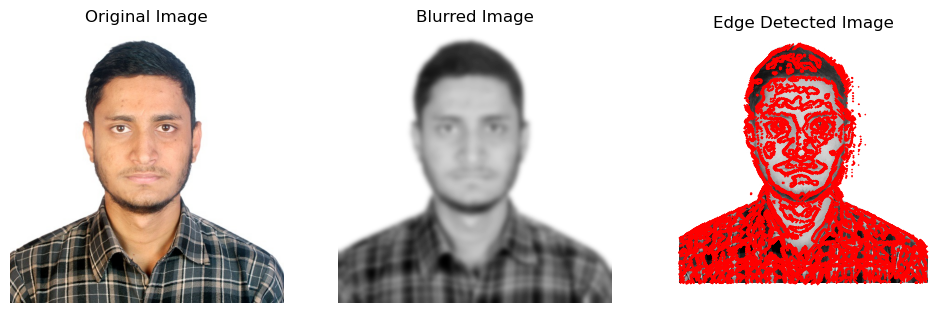

In [120]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def construct_gaussian_pyramid(image, levels):
    pyramid = [image]

    for i in range(1, levels):
        pyramid.append(cv2.resize(pyramid[-1], (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR))

    return pyramid

def subtract_interpolated(coarser_level, high_res_image):
    interpolated_coarser_level = cv2.resize(coarser_level, (high_res_image.shape[1], high_res_image.shape[0]), interpolation=cv2.INTER_LINEAR)
    residual_image = high_res_image - interpolated_coarser_level
    return residual_image

def count_zero_crossings(image, i, j):
    neighborhood = [image[i-1, j-1], image[i-1, j], image[i, j-1], image[i, j]]
    zero_crossings = 0

    if (neighborhood[0] * neighborhood[1] < 0) or (neighborhood[2] * neighborhood[3] < 0):
        zero_crossings += 1

    if (neighborhood[0] * neighborhood[2] < 0) or (neighborhood[1] * neighborhood[3] < 0):
        zero_crossings += 1

    return zero_crossings

def compute_edgel(image, i, j):
    dx = image[i+1, j] - image[i-1, j]
    dy = image[i, j+1] - image[i, j-1]

    if abs(dx) > abs(dy):
        x1 = j - dx / 2
        y1 = i - (dx / 2) * (dy / abs(dy))
        x2 = j + dx / 2
        y2 = i + (dx / 2) * (dy / abs(dy))
    else:
        x1 = j - (dy / 2) * (dx / abs(dx))
        y1 = i - dy / 2
        x2 = j + (dy / 2) * (dx / abs(dx))
        y2 = i + dy / 2

    gradient_magnitude = np.sqrt(dx**2 + dy**2)

    return x1, y1, x2, y2, gradient_magnitude


image = cv2.imread("image.jpeg")
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


blurred_image = cv2.GaussianBlur(image_gray.astype(np.float64), (0, 0), 5)


pyramid_levels = 5
pyramid = construct_gaussian_pyramid(blurred_image, pyramid_levels)

#Subtract interpolated levels and detect edges
edges = []

for i in range(1, pyramid_levels):
    residual_image = subtract_interpolated(pyramid[i], blurred_image)
    
    for i in range(1, residual_image.shape[0]-1):
        for j in range(1, residual_image.shape[1]-1):
            zero_crossings = count_zero_crossings(residual_image, i, j)

            if zero_crossings == 2:
                x1, y1, x2, y2, gradient_magnitude = compute_edgel(residual_image, i, j)
                edges.append([x1, y1, x2, y2, gradient_magnitude])


fig, axes = plt.subplots(1, 3, figsize=(12, 8))

axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(blurred_image, cmap='gray')
axes[1].set_title('Blurred Image')
axes[1].axis('off')

edges = np.array(edges)
axes[2].imshow(image_gray, cmap='gray')
axes[2].plot(edges[:, [0, 2]].T, edges[:, [1, 3]].T, 'r-', lw=1)
axes[2].set_title('Edge Detected Image')
axes[2].axis('off')

plt.show()
